# Time Series

- https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
- https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a

In [23]:
!pip install tbats

     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 1.5MB 9.4MB/s 


In [0]:
# importar pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#import matplotlib.pyplot as plt
import pickle
from tbats import TBATS, BATS

In [0]:
# definir parâmetros extras
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [0]:
# definir parâmetros extras
pd.set_option('precision', 4)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [0]:
#input_prefix = 'data/'
input_prefix = 'https://github.com/hjort/ai-labs/raw/master/jupyter/sales-russia/data/'

bzfile = '.bz2' # ''

In [5]:
df_train = pd.read_csv(
    input_prefix + '../sales_monthly.csv' + bzfile, #nrows=10000,
    #input_prefix + '../sales_monthly_full.csv' + bzfile, #nrows=10000,
    #input_prefix + '../train_full.csv' + bzfile, #nrows=10000,
    dtype={'date_block_num': np.int8, 'shop_id': np.int8, 'item_id': np.int16,
           'item_price_mean': np.int32, 'item_cnt_sum': np.int32,
           'city_code': 'category', 'item_category_id': 'category',
           'subject_code': 'category', 'group_code': 'category', 'subgroup_code': 'category'},
    index_col=['shop_id', 'item_id', 'date_block_num']
)
print('shape:', df_train.shape)
df_train.head()

shape: (1608226, 2)


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
0       30      1                           265            31
        31      1                           434            11
        32      0                           221             6
                1                           221            10
        33      0                           347             3

In [0]:
data = df_train.copy()
#data = df_train.drop(columns=['city_code', 'item_category_id', 'subject_code', 'group_code', 'subgroup_code'])

In [7]:
data.head()

item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
0       30      1                           265            31
        31      1                           434            11
        32      0                           221             6
                1                           221            10
        33      0                           347             3

In [0]:
data = data.query('(shop_id == 5) & (item_id == 5037)')
#data = data.query('(shop_id == 28) & (item_id == 20949)')
#data = data.query('(shop_id == 31) & (item_id == 20949)')
#data = data.query('(shop_id == 55) & (item_id == 492)')

In [9]:
data.head()

item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
5       5037    20                         2599             1
                22                         2599             1
                23                         1999             2
                24                         1999             2
                28                         1299             1

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9 entries, (5, 5037, 20) to (5, 5037, 32)
Data columns (total 2 columns):
item_price_mean    9 non-null int32
item_cnt_sum       9 non-null int32
dtypes: int32(2)
memory usage: 171.4 KB


In [11]:
data = data.reset_index().drop(columns=['shop_id', 'item_id']).set_index('date_block_num')
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599,1
22,2599,1
23,1999,2
24,1999,2
28,1299,1


In [12]:
data = pd.merge(pd.DataFrame({'date_block_num': np.arange(data.index.min(), 34)}).set_index('date_block_num'),
         data, how='left', left_index=True, right_index=True)
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599.0,1.0
21,NaN,NaN
22,2599.0,1.0
23,1999.0,2.0
24,1999.0,2.0


In [13]:
data.tail()

,item_price_mean,item_cnt_sum
date_block_num,,
29,1499.0,1.0
30,1499.0,1.0
31,1000.0,3.0
32,750.0,1.0
33,NaN,NaN


In [14]:
data['item_cnt_sum'] = data['item_cnt_sum'].fillna(0).astype(np.int32)
data['item_price_mean'] = data['item_price_mean'].fillna(method='bfill').fillna(method='ffill').astype(np.int32)
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599,1
21,2599,0
22,2599,1
23,1999,2
24,1999,2


In [15]:
data.tail()

,item_price_mean,item_cnt_sum
date_block_num,,
29,1499,1
30,1499,1
31,1000,3
32,750,1
33,750,0


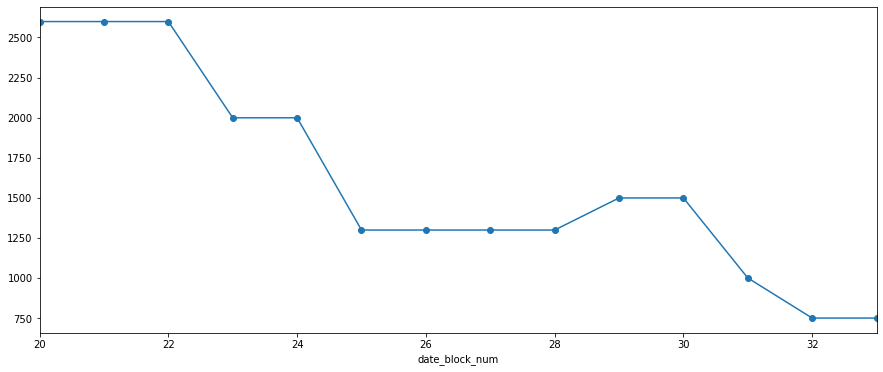

In [16]:
data['item_price_mean'].plot(marker='o')

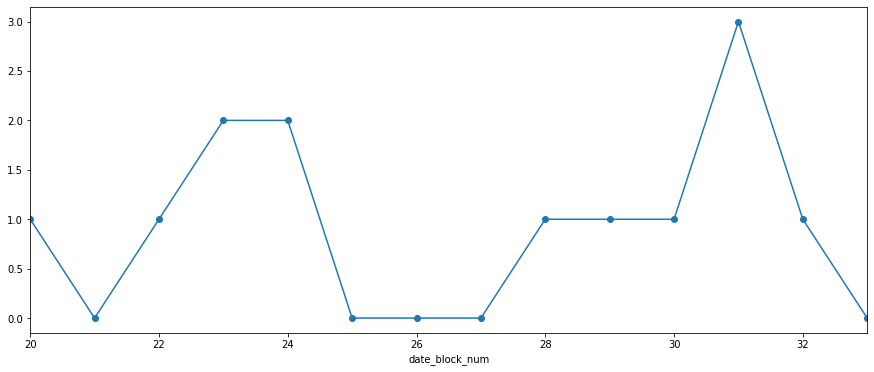

In [17]:
data['item_cnt_sum'].plot(marker='o')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe070d4a8d0>,
      dtype=object)

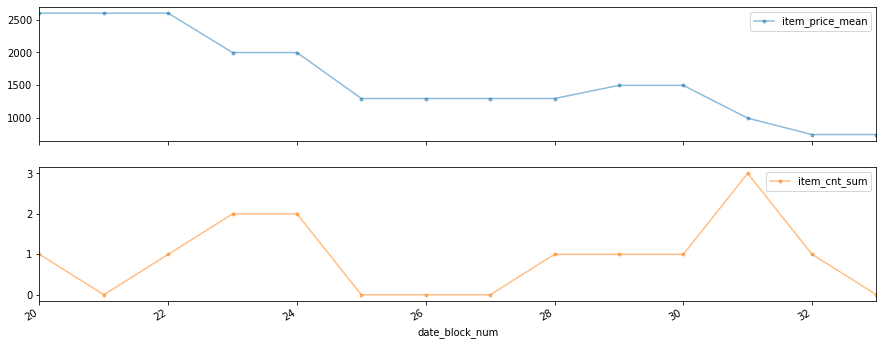

In [18]:
data.plot(marker='.', alpha=0.5, subplots=True)

# definir períodos a serem considerados no modelo
periodo1 = 1.0
periodo2 = 365.25

# definir data inicial de corte
data_inicio_amostra = '2014-11'

print('Períodos sazonais: (%.2f, %.2f)' % (periodo1, periodo2))
print('Data de início da amostra:', data_inicio_amostra)

In [19]:
y = data['item_cnt_sum']

tamanho = len(y)
corte = int(np.ceil(tamanho * 0.75))
resto = tamanho - corte
print('Tamanho: %-3d\nCorte:   %-3d\nResto:    %-3d' % (tamanho, corte, resto))

y_train = y.iloc[:corte]
y_test = y.iloc[corte:]

Tamanho: 14 
Corte:   11 
Resto:    3  


In [20]:
y_train[:5]

date_block_num
20    1
21    0
22    1
23    2
24    2
Name: item_cnt_sum, dtype: int32

In [21]:
y_test[-5:]

date_block_num
31    3
32    1
33    0
Name: item_cnt_sum, dtype: int32

In [25]:
# Fit the model
estimator = TBATS(seasonal_periods=(12,), n_jobs=8)
%time model = estimator.fit(y_train)

CPU times: user 495 ms, sys: 120 ms, total: 615 ms
Wall time: 6.49 s


In [26]:
# Forecast 365 days ahead
y_forecast = model.forecast(steps=resto)
print(y_forecast)

y_forecast = y_forecast.round().astype(np.int32)
y_forecast

[ 3.00000000e+00  1.00000000e+00 -5.55111512e-16]


array([3, 1, 0], dtype=int32)

In [27]:
y_true = y[-resto:].values
y_true

array([3, 1, 0], dtype=int32)

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print('MSE:', mean_squared_error(y_true, y_forecast))
print('MAE:', mean_absolute_error(y_true, y_forecast))
print('R²:', r2_score(y_true, y_forecast))

MSE: 0.0
MAE: 0.0
R²: 1.0


In [29]:
%time model = estimator.fit(y)

CPU times: user 627 ms, sys: 114 ms, total: 741 ms
Wall time: 8.75 s


In [30]:
y_pred = model.forecast(steps=3)
y_pred = y_pred.round().clip(0, 20).astype(np.int32)
y_pred

array([1, 2, 2], dtype=int32)

In [0]:
data = df_train.copy()

In [32]:
data.head(10)

item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
0       30      1                           265            31
        31      1                           434            11
        32      0                           221             6
                1                           221            10
        33      0                           347             3
                1                           347             3
        35      0                           247             1
                1                           247            14
        36      1                           357             1
        40      1                           127             1

In [33]:
df_test = pd.read_csv(
    input_prefix + 'test.csv' + bzfile, #nrows=10000,
    dtype={'shop_id': np.int8, 'item_id': np.int16},
    index_col='ID')
print('shape:', df_test.shape)
df_test.head()

shape: (214200, 2)


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [0]:
!rm -f prediction.csv && touch prediction.csv

In [138]:
filename = 'prediction.csv'
last_id = None

with open(filename) as infile:
  empty = (infile.read(1) == '')
  if (not empty):
    last_line = list(infile)[-1]
    last_id = int(last_line.split(',')[0])
infile.close()

outfile = open(filename, "a+", buffering=100)
if (empty):
  outfile.write('ID,item_cnt_month\n')
  print('File does not exist. Creating one.')
else:
  print('File already exists. Resuming from ID #%d' % last_id)

#for i in range(0, 10):
#  outfile.write("%d,%.1f\n" % (i, i%7))
#outfile.close()

File already exists. Resuming from ID #35


In [139]:
!cat prediction.csv

ID,item_cnt_month
0,1.0
1,0.0
2,0.0
3,1.0
4,0.0
5,0.0
6,1.0
7,9.0
8,20.0
9,0.0
10,4.0
11,0.0
12,0.0
13,8.0
14,4.0
15,3.0
16,0.0
17,0.0
18,6.0
19,0.0
20,0.0
21,0.0
22,1.0
23,0.0
24,3.0
25,0.0
26,0.0
27,1.0
28,2.0
29,16.0
30,2.0
31,0.0
32,2.0
33,3.0
34,2.0
35,0.0


In [0]:
estimator = TBATS(seasonal_periods=(12,), n_jobs=8)

for index, row in df_test.iterrows():
#for index, row in df_test.head(10).iterrows():
    if (last_id and index <= last_id):
      continue

    shop_id = row['shop_id']
    item_id = row['item_id']

    df_sale = df_train.query('(shop_id == %d) & (item_id == %d)' % (shop_id, item_id))
    if (not df_sale.empty):

      df_sale = df_sale.reset_index().drop(columns=['shop_id', 'item_id']).set_index('date_block_num')
      df_sale = pd.merge(
        pd.DataFrame({'date_block_num': np.arange(df_sale.index.min(), 34)}).set_index('date_block_num'),
        df_sale, how='left', left_index=True, right_index=True)
      df_sale['item_cnt_sum'] = df_sale['item_cnt_sum'].fillna(0).astype(np.int32)
      df_sale['item_price_mean'] = df_sale['item_price_mean'].fillna(
        method='bfill').fillna(method='ffill').astype(np.int32)

      model = estimator.fit(df_sale['item_cnt_sum'])

      y_pred = model.forecast(steps=1)
      y_pred = y_pred[0].round().clip(0, 20)
      #y_pred = y_pred[0].round().clip(0, 20).astype(np.int32)
    else:
      y_pred = 0
    
    print(index, shop_id, item_id, y_pred)
    outfile.write("%d,%.1f\n" % (index, y_pred))

    if (index % 10 == 0):
      outfile.flush()

outfile.close()

36 5 5674 3.0


/usr/local/lib/python3.6/dist-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


37 5 5671 1.0
38 5 5845 0.0
39 5 5841 0.0
40 5 5840 0.0


/usr/local/lib/python3.6/dist-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41 5 5820 1.0
42 5 5821 4.0
43 5 5822 3.0
44 5 5824 0.0
45 5 5826 0
46 5 5827 0.0
47 5 5828 0.0
48 5 5829 0.0
49 5 5837 2.0
50 5 5838 4.0
51 5 5839 0.0
52 5 5459 0.0
53 5 5830 0.0
54 5 3731 20.0
55 5 4719 0.0
56 5 3341 0.0
57 5 3343 4.0
58 5 3350 1.0
59 5 3351 0.0


/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


60 5 3352 10.0
61 5 3364 0.0
62 5 3365 0.0
63 5 3537 0.0
64 5 3538 0
65 5 3571 0
66 5 3676 1.0
67 5 3677 1.0
68 5 3678 0.0
69 5 3686 0.0
70 5 3604 0
71 5 3353 5.0
72 5 3334 0.0
73 5 3331 2.0
74 5 3407 0
75 5 3408 0
76 5 5962 0.0
77 5 3405 0
78 5 3423 1.0
79 5 3442 0.0
80 5 3443 1.0
81 5 3444 20.0


/usr/local/lib/python3.6/dist-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


In [0]:
ids = df_test.index
ids

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            214190, 214191, 214192, 214193, 214194, 214195, 214196, 214197,
            214198, 214199],
           dtype='int64', name='ID', length=214200)

In [0]:
X_pred = df_test.copy().reset_index().drop(columns=['ID'])
X_pred.head()

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [0]:
df_shops = pd.read_csv(
    input_prefix + '../shops_full' + '.csv' + bzfile,
    dtype={'city_code': 'category'},
    index_col='shop_id')
print('shape:', df_shops.shape)
df_shops.drop(columns=['shop_name', 'city_name'], inplace=True)
df_shops.head()

shape: (60, 3)


,city_code
shop_id,
0,1
1,1
2,2
3,3
4,4


In [0]:
df_items = pd.read_csv(
    input_prefix + '../items_full' + '.csv' + bzfile,
    dtype={'item_category_id': 'category', 'subject_code': 'category',
           'group_code': 'category', 'subgroup_code': 'category'},
    index_col='item_id')
print('shape:', df_items.shape)
df_items.drop(columns=['item_name', 'subject_name', 'item_category_name', 'group_name', 'subgroup_name'], inplace=True)
df_items.head()

shape: (22170, 9)


,item_category_id,subject_code,group_code,subgroup_code
item_id,,,,
0,40,1803,11,8
1,76,111,15,31
2,40,1614,11,8
3,40,1958,11,8
4,40,2630,11,8


In [0]:
X_pred['date_block_num'] = 34
X_pred['item_price_mean'] = 0
X_pred.set_index(['shop_id', 'item_id', 'date_block_num'], inplace=True)
X_pred.head()

item_price_mean
shop_id item_id date_block_num                 
5       5037    34                            0
        5320    34                            0
        5233    34                            0
        5232    34                            0
        5268    34                            0

In [0]:
X_pred = X_pred.join(df_shops).join(df_items)
X_pred.head()

item_price_mean city_code item_category_id  \
shop_id item_id date_block_num                                               
5       5037    34                            0         5               19   
        5320    34                            0         5               55   
        5233    34                            0         5               19   
        5232    34                            0         5               23   
        5268    34                            0         5               20   

                               subject_code group_code subgroup_code  
shop_id item_id date_block_num                                        
5       5037    34                      793          6            13  
        5320    34                      818         13             6  
        5233    34                      786          6            13  
        5232    34                      786          6            19  
        5268    34                      786          6            14

In [0]:
y_pred = model.predict(X_pred)
y_pred[:30]

array([ 1.88292211,  2.03189192,  1.88292211,  1.85285458,  2.18216991,
        1.85285458,  2.18216991,  2.03189192,  2.03189192,  2.18216991,
        2.06270293,  2.18216991,  2.03189192,  1.85285458,  1.85285458,
        1.88292211, 11.78756569,  2.03189192,  2.06270293,  2.18216991,
        2.03189192,  1.88292211,  2.24096826,  1.88292211,  2.06270293,
        2.18216991,  1.85285458,  2.11946414,  2.34529601,  2.34529601])

In [0]:
#y_pred = np.clip(y_pred, 0, 20)
#y_pred = np.clip(np.round(y_pred), 0, 20)
y_pred = np.clip(np.floor(y_pred), 0, 20)
y_pred[:30]

array([ 1.,  2.,  1.,  1.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        1.,  1.,  1., 11.,  2.,  2.,  2.,  2.,  1.,  2.,  1.,  2.,  2.,
        1.,  2.,  2.,  2.])

In [0]:
df_final = pd.DataFrame(data=y_pred, columns=['item_cnt_month'], index=ids)
df_final.index.names = ['ID']
df_final.head()

,item_cnt_month
ID,
0,1.0
1,2.0
2,1.0
3,1.0
4,2.0


In [0]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 1 columns):
item_cnt_month    214200 non-null float64
dtypes: float64(1)
memory usage: 3.3 MB


In [0]:
df_final.describe()

,item_cnt_month
count,214200.0000
mean,5.0916
std,6.0712
min,0.0000
25%,1.0000
50%,3.0000
75%,5.0000
max,20.0000


In [0]:
df_final.to_csv('submission6.csv')